In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from datasets import DatasetDict, Datasets
from transformers import AutoTokenizer, TFBertModel
import tensorflow as tf
from sklearn.model_selection import train_test_split
import pickle

## Data Preparation

In [8]:
df = pd.read_csv('../Data/STAGE 4 FINAL MERGED DATA/STAGE_4_MERGED_FINAL_ENCODED.csv')

In [9]:
df

,klasifikasi_perkara_encoded,penuntut_umum_encoded,hakim_encoded,jumlah_saksi,maks_penjara_berdasarkan_pasal,terdakwa,summarized_dakwaan,total_pidana_penjara_bulan
0,0,0,0,6,80,GEDE DARMAYASA,Terdakwa Gede Darmayasa didakwa telah melakuka...,5.0
1,1,1,1,4,48,IDA BAGUS MADE DARMA WIGUNA,"Pada bulan Februari dan Maret 2024, terdakwa I...",24.0
2,0,0,2,6,84,HANDRI JOHANAS,"Terdakwa Handri Johanes pada Rabu, 24 April 20...",4.0
3,2,2,1,2,144,I GEDE ARIADI alias BERNAD,"Pada hari Minggu, 14 April 2024 sekitar pukul ...",14.0
4,2,3,1,2,144,I GEDE ARIADI alias BERNAD,"Pada hari Minggu, 14 April 2024 sekitar pukul ...",14.0
...,...,...,...,...,...,...,...,...
4318,2,347,128,2,240,NURUL FIQRI SUDIRMAN als KIKI bin SUDIRMAN,"Pada Jumat, 31 Maret 2023, sekitar pukul 20.30...",72.0
4319,0,361,117,2,84,SUPRIADI BIN RATIM,"Pada hari Minggu, 28 Mei 2023, sekitar pukul 1...",16.0
4320,0,363,117,2,84,SUPRIADI BIN RATIM,"Pada hari Minggu, 28 Mei 2023, sekitar pukul 1...",16.0
4321,0,361,117,2,84,ANWAR RURI BIN SYARIFUDIN USMAN,"Pada hari Minggu, 28 Mei 2023, sekitar pukul 1...",16.0


In [10]:
df_filtered = df.copy()

In [11]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4323 entries, 0 to 4322
Data columns (total 8 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   klasifikasi_perkara_encoded     4323 non-null   int64  
 1   penuntut_umum_encoded           4323 non-null   int64  
 2   hakim_encoded                   4323 non-null   int64  
 3   jumlah_saksi                    4323 non-null   int64  
 4   maks_penjara_berdasarkan_pasal  4323 non-null   int64  
 5   terdakwa                        4323 non-null   object 
 6   summarized_dakwaan              4323 non-null   object 
 7   total_pidana_penjara_bulan      4323 non-null   float64
dtypes: float64(1), int64(5), object(2)
memory usage: 270.3+ KB


### Split Data

In [12]:
def stratified_split(df: pd.DataFrame, split_size: float = 0.8) -> tuple[pd.DataFrame, pd.DataFrame]:
    unique_groups = df.groupby(["klasifikasi_perkara_encoded", "penuntut_umum_encoded", "hakim_encoded"]).apply(lambda x: x.index.tolist()).to_dict()
    
    print(unique_groups)
    train_idx, test_idx = [], []
    
    for indices in unique_groups.values():        
        if len(indices) == 1:
            train_idx.extend(indices)
        else:
            train, test = train_test_split(indices, train_size=split_size, random_state=42)
            train_idx.extend(train)
            test_idx.extend(test)
    
    return df.loc[train_idx], df.loc[test_idx]

In [13]:
train_df, test_df = stratified_split(df_filtered)

{(0, 0, 0): [0, 20], (0, 0, 2): [2], (0, 1, 0): [19], (0, 1, 4): [35, 36], (0, 4, 1): [5], (0, 4, 3): [10], (0, 7, 1): [9], (0, 8, 0): [15, 17], (0, 9, 0): [16, 18], (0, 11, 4): [22, 23], (0, 13, 0): [32], (0, 13, 3): [34], (0, 15, 4): [33], (0, 16, 0): [37], (0, 17, 0): [38], (0, 17, 14): [437, 501, 595, 609], (0, 17, 16): [422], (0, 17, 18): [474, 665], (0, 17, 19): [783, 784, 785, 786], (0, 17, 20): [432, 438, 518, 578, 608, 724, 745], (0, 17, 21): [639, 822], (0, 18, 0): [39], (0, 19, 0): [40, 41], (0, 20, 0): [42], (0, 22, 7): [46], (0, 26, 10): [52, 54], (0, 27, 10): [136, 152, 172], (0, 27, 11): [75, 104], (0, 27, 12): [173], (0, 27, 14): [119], (0, 28, 10): [100, 147], (0, 28, 11): [55], (0, 29, 10): [56], (0, 30, 10): [57, 94], (0, 30, 12): [90], (0, 31, 9): [58], (0, 31, 10): [106, 107, 109], (0, 31, 12): [96, 97], (0, 32, 10): [59, 60, 61], (0, 32, 12): [101, 102], (0, 33, 10): [174], (0, 33, 14): [144, 162, 163, 164, 166, 177], (0, 34, 10): [63, 91, 92, 93], (0, 34, 11): [6

C:\Users\Kalea\AppData\Local\Temp\ipykernel_5768\635274658.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  unique_groups = df.groupby(["klasifikasi_perkara_encoded", "penuntut_umum_encoded", "hakim_encoded"]).apply(lambda x: x.index.tolist()).to_dict()


In [14]:
jenis_klasifikasi_perkara = train_df['klasifikasi_perkara_encoded'].unique()
jumlah_klasifikasi_perkara = len(jenis_klasifikasi_perkara)
print(f"Jumlah Klasifikasi Perkara: {jumlah_klasifikasi_perkara}")
print(f"Jumlah Data Train:  {len(train_df)}")

klasifikasi_perkara_values = train_df['klasifikasi_perkara_encoded'].value_counts()
print(klasifikasi_perkara_values)

Jumlah Klasifikasi Perkara: 5
Jumlah Data Train:  3288
klasifikasi_perkara_encoded
0    1384
2    1253
3     293
4     194
1     164
Name: count, dtype: int64


In [15]:
jenis_klasifikasi_perkara = test_df['klasifikasi_perkara_encoded'].unique()
jumlah_klasifikasi_perkara = len(jenis_klasifikasi_perkara)
print(f"Jumlah Klasifikasi Perkara: {jumlah_klasifikasi_perkara}")
print(f"Jumlah Data Test:  {len(test_df)}")

klasifikasi_perkara_values = test_df['klasifikasi_perkara_encoded'].value_counts()
print(klasifikasi_perkara_values)

Jumlah Klasifikasi Perkara: 5
Jumlah Data Test:  1035
klasifikasi_perkara_encoded
0    484
2    436
4     50
3     44
1     21
Name: count, dtype: int64


In [16]:
df_filtered

,klasifikasi_perkara_encoded,penuntut_umum_encoded,hakim_encoded,jumlah_saksi,maks_penjara_berdasarkan_pasal,terdakwa,summarized_dakwaan,total_pidana_penjara_bulan
0,0,0,0,6,80,GEDE DARMAYASA,Terdakwa Gede Darmayasa didakwa telah melakuka...,5.0
1,1,1,1,4,48,IDA BAGUS MADE DARMA WIGUNA,"Pada bulan Februari dan Maret 2024, terdakwa I...",24.0
2,0,0,2,6,84,HANDRI JOHANAS,"Terdakwa Handri Johanes pada Rabu, 24 April 20...",4.0
3,2,2,1,2,144,I GEDE ARIADI alias BERNAD,"Pada hari Minggu, 14 April 2024 sekitar pukul ...",14.0
4,2,3,1,2,144,I GEDE ARIADI alias BERNAD,"Pada hari Minggu, 14 April 2024 sekitar pukul ...",14.0
...,...,...,...,...,...,...,...,...
4318,2,347,128,2,240,NURUL FIQRI SUDIRMAN als KIKI bin SUDIRMAN,"Pada Jumat, 31 Maret 2023, sekitar pukul 20.30...",72.0
4319,0,361,117,2,84,SUPRIADI BIN RATIM,"Pada hari Minggu, 28 Mei 2023, sekitar pukul 1...",16.0
4320,0,363,117,2,84,SUPRIADI BIN RATIM,"Pada hari Minggu, 28 Mei 2023, sekitar pukul 1...",16.0
4321,0,361,117,2,84,ANWAR RURI BIN SYARIFUDIN USMAN,"Pada hari Minggu, 28 Mei 2023, sekitar pukul 1...",16.0


In [17]:
train_df

,klasifikasi_perkara_encoded,penuntut_umum_encoded,hakim_encoded,jumlah_saksi,maks_penjara_berdasarkan_pasal,terdakwa,summarized_dakwaan,total_pidana_penjara_bulan
0,0,0,0,6,80,GEDE DARMAYASA,Terdakwa Gede Darmayasa didakwa telah melakuka...,5.0
2,0,0,2,6,84,HANDRI JOHANAS,"Terdakwa Handri Johanes pada Rabu, 24 April 20...",4.0
19,0,1,0,4,60,I NYOMAN BUDIAWAN Als. SUMAWAN,"Pada hari Rabu, 25 Oktober 2023 sekitar pukul ...",14.0
35,0,1,4,3,84,RIFQI ABDURAHMAN,"Pada Minggu, 11 Desember 2022 sekitar pukul 00...",8.0
5,0,4,1,4,60,R. Sabirin,"Pada hari Selasa, 26 Maret 2024 sekitar pukul ...",14.0
...,...,...,...,...,...,...,...,...
4094,4,372,129,2,120,JOYO CIPTO alias TOTO Bin SALIMIN,"Pada hari Minggu, 09 Juli 2023, sekitar pukul ...",8.0
4089,4,372,129,2,120,FERI Bin TAMIN,"Pada Minggu, 09 Juli 2023, sekitar pukul 00.15...",8.0
4088,4,372,129,2,120,AHMAD JUMADI alias MADI Bin SUBUR,"Pada Minggu, 09 Juli 2023, sekitar pukul 00.15...",8.0
4091,4,372,129,2,120,SARONI Bin RASKI,"Pada hari Minggu, 09 Juli 2023, sekitar pukul ...",8.0


## Model

### Model Preprocessing

In [18]:
train_df['concat_text'] = train_df[['terdakwa','summarized_dakwaan']].apply(lambda x: ' '.join(x), axis=1)
test_df['concat_text'] = test_df[['terdakwa','summarized_dakwaan']].apply(lambda x: ' '.join(x), axis=1)

In [19]:
y_train = train_df['total_pidana_penjara_bulan']
y_test = test_df['total_pidana_penjara_bulan']

In [21]:
# LOG TRANSFORMATION
y_train = np.log1p(y_train)
y_test = np.log1p(y_test)

### Tokenizer

In [20]:
tokenizer = AutoTokenizer.from_pretrained("indolem/indobert-base-uncased")

def tokenize_function(text):
    return tokenizer(text['concat_text'], padding='max_length', truncation=True, max_length=512)

train_encodings = tokenizer(train_df['concat_text'].tolist(), padding=True, truncation=True, max_length=512)
test_encodings = tokenizer(test_df['concat_text'].tolist(), padding=True, truncation=True, max_length=512)

print(tokenizer.truncation_side)

right


### Convert to Tensor

In [22]:
train_inputs = tf.constant(train_encodings['input_ids'])
train_attention_masks = tf.constant(train_encodings['attention_mask'])

test_inputs = tf.constant(test_encodings['input_ids'])
test_attention_masks = tf.constant(test_encodings['attention_mask'])

train_numerical = tf.constant(train_df[['klasifikasi_perkara_encoded', 'penuntut_umum_encoded', 'hakim_encoded', 'jumlah_saksi', 'maks_penjara_berdasarkan_pasal']].values, dtype=tf.float32)
test_numerical = tf.constant(test_df[['klasifikasi_perkara_encoded', 'penuntut_umum_encoded', 'hakim_encoded', 'jumlah_saksi', 'maks_penjara_berdasarkan_pasal']].values, dtype=tf.float32)

train_labels = tf.constant(y_train.values, dtype=tf.float32)
test_labels = tf.constant(y_test.values, dtype=tf.float32)

### Create Tensor Dataset

In [23]:
import tensorflow as tf

def create_bert_regressor_dataset(input_ids, attention_mask, numerical_features, labels):
    dataset = tf.data.Dataset.from_tensor_slices(({
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'numerical_feature': numerical_features
    }, labels))
    return dataset

train_dataset = create_bert_regressor_dataset(train_inputs, train_attention_masks, train_numerical, train_labels)
test_dataset = create_bert_regressor_dataset(test_inputs, test_attention_masks, test_numerical, test_labels)

train_dataset = train_dataset.batch(2)
test_dataset = test_dataset.batch(2)


### Model Architecture

In [ ]:
# bert = TFBertModel.from_pretrained("indolem/indobert-base-uncased", from_pt=True)

# encoder = bert.bert.encoder

# for i, encoder_layer in enumerate(encoder.layer):
#     print(f"Encoder Layer {i}")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predict

Encoder Layer 0
Encoder Layer 1
Encoder Layer 2
Encoder Layer 3
Encoder Layer 4
Encoder Layer 5
Encoder Layer 6
Encoder Layer 7
Encoder Layer 8
Encoder Layer 9
Encoder Layer 10
Encoder Layer 11


In [24]:
class BERTRegressor(tf.keras.Model):
    def __init__(self):
        super(BERTRegressor, self).__init__()
        self.bert = TFBertModel.from_pretrained("indolem/indobert-base-uncased", from_pt=True)

        for layer in self.bert.layers:
            layer.trainable = True
            
        self.regressor = tf.keras.layers.Dense(1)

    def call(self, inputs):
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        numerical_features = inputs['numerical_feature']

        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = bert_output.pooler_output

        combined_output = tf.concat([pooled_output, numerical_features], axis=1)

        return self.regressor(combined_output)

model = BERTRegressor()


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predict

In [25]:
encoder = model.bert.bert.encoder

for i, encoder_layer in enumerate(encoder.layer):
    print(f"Encoder Layer {i} — trainable: {encoder_layer.trainable}")

Encoder Layer 0 — trainable: True
Encoder Layer 1 — trainable: True
Encoder Layer 2 — trainable: True
Encoder Layer 3 — trainable: True
Encoder Layer 4 — trainable: True
Encoder Layer 5 — trainable: True
Encoder Layer 6 — trainable: True
Encoder Layer 7 — trainable: True
Encoder Layer 8 — trainable: True
Encoder Layer 9 — trainable: True
Encoder Layer 10 — trainable: True
Encoder Layer 11 — trainable: True


### Compile Model

In [26]:
reduce_lr_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5)

In [27]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=tf.keras.losses.Huber(), metrics=['mean_absolute_error', tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsolutePercentageError()])

### Train Model

In [28]:
history = model.fit(train_dataset, epochs=50, batch_size=32, 
                    validation_data=test_dataset,
                    callbacks=[reduce_lr_on_plateau])

Epoch 1/50
1644/1644 [==============================] - 282s 165ms/step - loss: 1.7928 - mean_absolute_error: 2.1684 - root_mean_squared_error: 5.2389 - mean_absolute_percentage_error: 95.2693 - val_loss: 7.4707 - val_mean_absolute_error: 7.9494 - val_root_mean_squared_error: 10.4656 - val_mean_absolute_percentage_error: 285.5786 - lr: 1.0000e-04
Epoch 2/50
1644/1644 [==============================] - 269s 164ms/step - loss: 2.0998 - mean_absolute_error: 2.4321 - root_mean_squared_error: 5.3699 - mean_absolute_percentage_error: 94.3536 - val_loss: 4.1276 - val_mean_absolute_error: 4.6214 - val_root_mean_squared_error: 5.6542 - val_mean_absolute_percentage_error: 162.1615 - lr: 1.0000e-04
Epoch 3/50
1644/1644 [==============================] - 270s 164ms/step - loss: 0.7307 - mean_absolute_error: 1.0445 - root_mean_squared_error: 2.1887 - mean_absolute_percentage_error: 39.0328 - val_loss: 1.3563 - val_mean_absolute_error: 1.8205 - val_root_mean_squared_error: 2.2681 - val_mean_absolute

In [35]:
loss = model.evaluate(test_dataset)
print(f'Model Loss: {loss}')

518/518 [==============================] - 24s 45ms/step - loss: 0.2749 - mean_absolute_error: 0.6320 - root_mean_squared_error: 0.7581 - mean_absolute_percentage_error: 21.3560
Model Loss: [0.2748589813709259, 0.631985604763031, 0.758074164390564, 21.35602569580078]


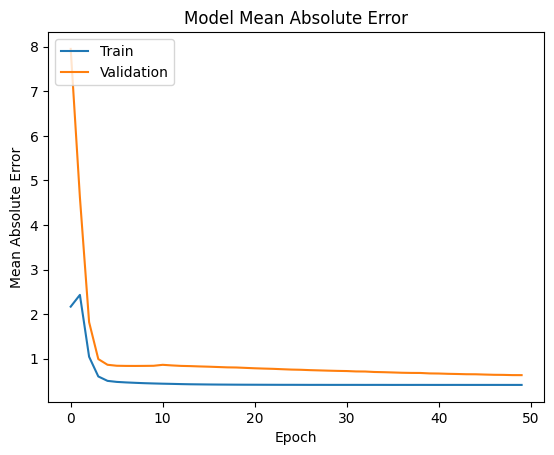

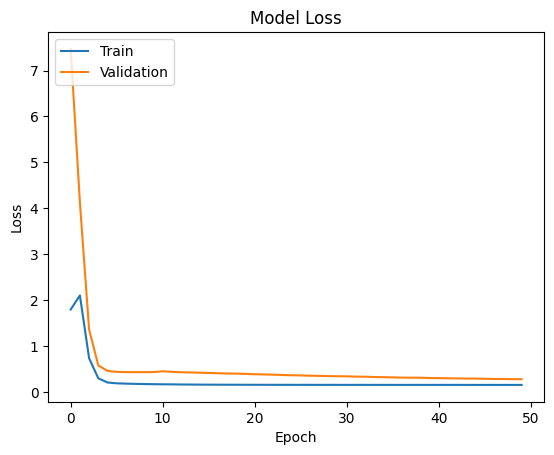

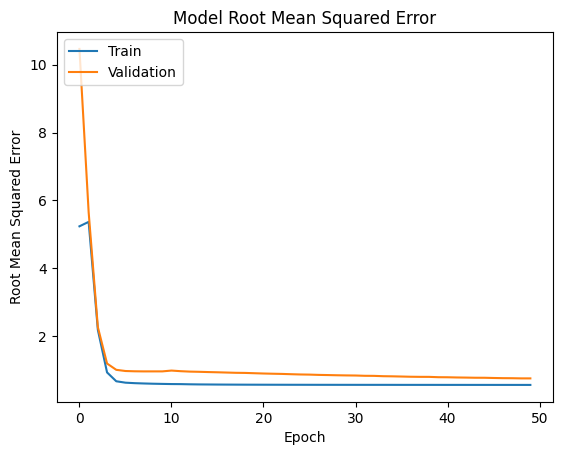

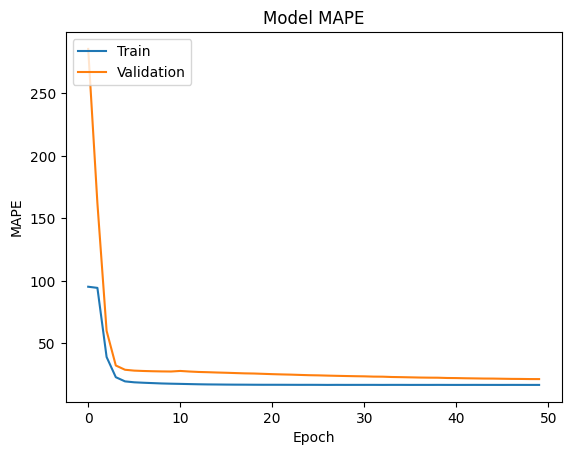

In [36]:
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('Model Mean Absolute Error')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('Model Root Mean Squared Error')
plt.ylabel('Root Mean Squared Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['mean_absolute_percentage_error'])
plt.plot(history.history['val_mean_absolute_percentage_error'])
plt.title('Model MAPE')
plt.ylabel('MAPE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Inference

In [31]:
klasifikasi_perkara_encoded = 0
penuntut_umum_encoded = 0
hakim_encoded = 7
jumlah_saksi_inference = 6
maks_penjara_berdasarkan_pasal = 84


inference_text = ["buah sabit gagang kayu buah jare plastik paranet warna hitam uta tali plastik warna biru meter puluh buah kantong plastik kresek uta tali kain warna merah cm dimusnahkan unit mobil merek suzuki st pick up warna hitam dk kc noka mhyesljj nosin gaid beserta kunci kontak lembar stnk mobil merek suzuki st pick up warna hitam dk kc noka mhyesljj nosin gaid nama pemilik an i kadek kondrayasa dikembalikan i gede agu wirayuda buah durian jeni durian kane dikembalikan i wayan sukaren lembar nota pembelian buah durian toko tiara durian dikembalikan komang ayu anggreni bela buah durian jeni durian kane lembar nota pembelian buah durian toko semut durian dikembalikan komang sujana uang tunai rp ratu delapan puluh tujuh ribu rupiah dirampa negara membebankan terdakwa membayar biaya perkara rp ribu rupiah terdakwa gede darmayasa selasa tanggal mei sekira jam wita selasa tanggal mei sekira jam wita sabtu tanggal mei sekira jam wita setidaktidaknya mei setidaktidaknya kebun milik i wayan sukerena banjar desa bunutin kecamatan kintamani kab bangli kebun milik i nyoman susila banjar desa bunutin kecamatan kintamani kab bangli kebun milik i ketut tindih banjar desa pengejaran kecamatan kintamani kab bangli setidaktidaknya daerah hukum pengadilan negeri bangli perbuatan dipandang perbuatan berdiri kejahatan mengambil barang kepunyaan orang maksud dimiliki melawan hukum terdakwa caracara selasa tanggal mei sekira wita terdakwa berangkat rumah terdakwa br dina pudeh ds tajun kec kubutambahan kab buleleng mobil suzuki carri pick up warna hitam dk kc pergi brd bunutin kec kintamani kab bangli melewati simpang pasar tenten kintamani tujuan memb menawarkan buah durian dipohonnya sesampainya terdakwa brd bunutin kec kintamani kab bangli sekira wita terdakwa pohon durian berbuah kebun milik i wayan sukerena dipinggir jalan raya ds bunutin kec kintamani kab bangli situasi sepi terdakwa melihatlihat buah durian menemukan buah dipetik terdakwa memetik buah durian memanjat pohon durian sabit memotong buah durian pohon bergiliran buah durian terdakwa petik puluh tujuh buahsetelah terkumpul buah durian terdakwa naikan mobil suzuki carri pick up warna hitam dk kc terdakwa kendarai buah durian diata mobil terdakwa meninggalkan kebun milik i wayan sukerena perjalanan terdakwa dipinggir jalan raya ds bunutin kintamani pohon durian berbuah terdakwa turun memarkir mobil suzuki carri pick up warna hitam dk kc dipinggir jalan raya berjalan kaki terdakwa kebun milik i nyoman susila brd bunutin kec kintamani kab bangli sekira wita pohon durian berbuah terdakwa memanjat pohon durian pohon bergantian memetik sabit menurunkan buah durian puluh tujuh buah buah durian turun terkumpul terdakwa naikan mobil suzuki carri pick up warna hitam dk kc terdakwa tutupi buah durian diata mobil jare plastik warna hitam terdakwa ikat tali plastik warna biru buah durian aman diata mobil terdakwa meninggalkan brd bunutin kec kintamani kab bangli rumah terdakwa br dina pudeh ds tajun kac kubutambahan kab buleleng dirumah wita terdakwa langsung menjual durian saksi komang ayu anggreni batu barak desa tajun kec kubutambahan kab buleleng puluh buah berat seratu delapan puluh kg harga rp juta ratu enam bela ribu rupiah sisa buah durian puluh tujuh buah terdakwa bawa pulang kerumah kami tanggal mei sekira wita terdakwa menjual durian jeni durian kane komang sujana gudang milik komang sujana puluh buah durian berat kg buah durian hasil mencuri selasa tanggal mei brd bunutin kec kintamani kab bangli buah durian hasil terdakwa memb petani terdakwa jual harga total rp juta ratu ribu rupiah sabtu tanggal mei sekira wita terdakwa berangkat rumah terdakwa br dina pudeh ds tajun kec kubutambahan kab buleleng mobil suzuki carri pick up warna hitam dk kc pergi brd pengejaran kec kintamani kab bangli sesampainya terdakwa brd pengejaran kec kintamani kab bangli sekira wita melewati simpang lampu terdakwa dikebun milik i ketut tindih berlokasi pinggir jalan raya ds pengejaran situasi sepi terdakwa memanjat pohon durian pohon bergantian memetik buah durian sabit buah menjatuhkan buah durian ketanah terdakwa mengumpulkan buah durian terdakwa petik terdakwa menaikan buah durian mobil carri terdakwa bawa buah durian terdakwa tutupi buah durian diata mobil jare plastik warna hitam terdakwa ikat tali plastik warna biru buah durian aman diata mobil terdakwa meninggalkan brd pengejaran kec kintamani kab bangli rumah terdakwa br dina pudeh ds tajun kac kubutambahan kab buleleng pulang kerumahnya terdakwa pergi desa tajun menjual buah durian komang ayu anggreni buah harga rp juta ratu delapan puluh ribu rupiah menjual buah durian terdakwa langsung pulang rumah terdakwa br dina pudeh ds tajun kac kubutambahan kab buleleng terdakwa mengambil enam puluh tujuh buah durian kane ijin saksi i wayan sukerena saksi i nyoman susila saksi i ketut tindih memiliki buah durian menjualnya uang hasil penjualan biaya hidup seharihari akibat perbuatan terdakwa mengakibatkan saksi i wayan sukerena mengalami kerugian rp juta ratu puluh ribu rupiah saksi i ketut tindih mengalami kerugian rp juta ratu ribu rupiah saksi i nyoman susila mengalami kerugian rp juta rupiah setidaktidaknya rp ratu puluh rupiah diatur diancam pidana pasal kuhp jo pasal ayat kuhp gede darmayasa"]
inference_numerical_tensor = tf.constant([[klasifikasi_perkara_encoded, penuntut_umum_encoded, hakim_encoded, jumlah_saksi_inference, maks_penjara_berdasarkan_pasal]], dtype=tf.float32)
inputs = tokenizer(inference_text, padding=True, truncation=True, return_tensors='tf', max_length=512)

input_dict = {
    'input_ids': inputs['input_ids'],
    'attention_mask': inputs['attention_mask'],
    'numerical_feature': inference_numerical_tensor
}

predictions = model(input_dict)
predictions_np = predictions.numpy()

print(predictions_np)


[[2.1444964]]


In [32]:
model_scenario_name = "indolem_indobert-base-uncased_FineTuning_Layer0_LogTransform_TargetOnly"

model_save_path = f'../Model/{model_scenario_name}'
history_training_save_path = f'../Model/{model_scenario_name}_training_history.pkl'

model.save(model_save_path)

with open(history_training_save_path, 'wb') as f:
    pickle.dump(history.history, f)

INFO:tensorflow:Assets written to: ../Model/indolem_indobert-base-uncased_FineTuning_Layer0_LogTransform_TargetOnly\assets


INFO:tensorflow:Assets written to: ../Model/indolem_indobert-base-uncased_FineTuning_Layer0_LogTransform_TargetOnly\assets


## Saved Model Inference (CHANGE ARCH BEFORE SAVING!)

In [33]:
tokenizer = AutoTokenizer.from_pretrained("indolem/indobert-base-uncased")

class BERTRegressor(tf.keras.Model):
    def __init__(self):
        super(BERTRegressor, self).__init__()
        self.bert = TFBertModel.from_pretrained("indolem/indobert-base-uncased", from_pt=True)
        for layer in self.bert.layers:
            layer.trainable = True
        self.regressor = tf.keras.layers.Dense(1)

    def call(self, inputs):
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        numerical_features = inputs['numerical_feature']

        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = bert_output.pooler_output
        combined_output = tf.concat([pooled_output, numerical_features], axis=1)

        return self.regressor(combined_output)

model_scenario_name = "indolem_indobert-base-uncased_FineTuning_Layer0_LogTransform_TargetOnly"
model_save_path = f'../Model/{model_scenario_name}'

loaded_model = tf.keras.models.load_model(model_save_path, custom_objects={'BERTRegressor': BERTRegressor})

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predict

In [34]:
klasifikasi_perkara_encoded = 0
penuntut_umum_encoded = 0
hakim_encoded = 7
jumlah_saksi_inference = 6
maks_penjara_berdasarkan_pasal = 84


inference_text = ["buah sabit gagang kayu buah jare plastik paranet warna hitam uta tali plastik warna biru meter puluh buah kantong plastik kresek uta tali kain warna merah cm dimusnahkan unit mobil merek suzuki st pick up warna hitam dk kc noka mhyesljj nosin gaid beserta kunci kontak lembar stnk mobil merek suzuki st pick up warna hitam dk kc noka mhyesljj nosin gaid nama pemilik an i kadek kondrayasa dikembalikan i gede agu wirayuda buah durian jeni durian kane dikembalikan i wayan sukaren lembar nota pembelian buah durian toko tiara durian dikembalikan komang ayu anggreni bela buah durian jeni durian kane lembar nota pembelian buah durian toko semut durian dikembalikan komang sujana uang tunai rp ratu delapan puluh tujuh ribu rupiah dirampa negara membebankan terdakwa membayar biaya perkara rp ribu rupiah terdakwa gede darmayasa selasa tanggal mei sekira jam wita selasa tanggal mei sekira jam wita sabtu tanggal mei sekira jam wita setidaktidaknya mei setidaktidaknya kebun milik i wayan sukerena banjar desa bunutin kecamatan kintamani kab bangli kebun milik i nyoman susila banjar desa bunutin kecamatan kintamani kab bangli kebun milik i ketut tindih banjar desa pengejaran kecamatan kintamani kab bangli setidaktidaknya daerah hukum pengadilan negeri bangli perbuatan dipandang perbuatan berdiri kejahatan mengambil barang kepunyaan orang maksud dimiliki melawan hukum terdakwa caracara selasa tanggal mei sekira wita terdakwa berangkat rumah terdakwa br dina pudeh ds tajun kec kubutambahan kab buleleng mobil suzuki carri pick up warna hitam dk kc pergi brd bunutin kec kintamani kab bangli melewati simpang pasar tenten kintamani tujuan memb menawarkan buah durian dipohonnya sesampainya terdakwa brd bunutin kec kintamani kab bangli sekira wita terdakwa pohon durian berbuah kebun milik i wayan sukerena dipinggir jalan raya ds bunutin kec kintamani kab bangli situasi sepi terdakwa melihatlihat buah durian menemukan buah dipetik terdakwa memetik buah durian memanjat pohon durian sabit memotong buah durian pohon bergiliran buah durian terdakwa petik puluh tujuh buahsetelah terkumpul buah durian terdakwa naikan mobil suzuki carri pick up warna hitam dk kc terdakwa kendarai buah durian diata mobil terdakwa meninggalkan kebun milik i wayan sukerena perjalanan terdakwa dipinggir jalan raya ds bunutin kintamani pohon durian berbuah terdakwa turun memarkir mobil suzuki carri pick up warna hitam dk kc dipinggir jalan raya berjalan kaki terdakwa kebun milik i nyoman susila brd bunutin kec kintamani kab bangli sekira wita pohon durian berbuah terdakwa memanjat pohon durian pohon bergantian memetik sabit menurunkan buah durian puluh tujuh buah buah durian turun terkumpul terdakwa naikan mobil suzuki carri pick up warna hitam dk kc terdakwa tutupi buah durian diata mobil jare plastik warna hitam terdakwa ikat tali plastik warna biru buah durian aman diata mobil terdakwa meninggalkan brd bunutin kec kintamani kab bangli rumah terdakwa br dina pudeh ds tajun kac kubutambahan kab buleleng dirumah wita terdakwa langsung menjual durian saksi komang ayu anggreni batu barak desa tajun kec kubutambahan kab buleleng puluh buah berat seratu delapan puluh kg harga rp juta ratu enam bela ribu rupiah sisa buah durian puluh tujuh buah terdakwa bawa pulang kerumah kami tanggal mei sekira wita terdakwa menjual durian jeni durian kane komang sujana gudang milik komang sujana puluh buah durian berat kg buah durian hasil mencuri selasa tanggal mei brd bunutin kec kintamani kab bangli buah durian hasil terdakwa memb petani terdakwa jual harga total rp juta ratu ribu rupiah sabtu tanggal mei sekira wita terdakwa berangkat rumah terdakwa br dina pudeh ds tajun kec kubutambahan kab buleleng mobil suzuki carri pick up warna hitam dk kc pergi brd pengejaran kec kintamani kab bangli sesampainya terdakwa brd pengejaran kec kintamani kab bangli sekira wita melewati simpang lampu terdakwa dikebun milik i ketut tindih berlokasi pinggir jalan raya ds pengejaran situasi sepi terdakwa memanjat pohon durian pohon bergantian memetik buah durian sabit buah menjatuhkan buah durian ketanah terdakwa mengumpulkan buah durian terdakwa petik terdakwa menaikan buah durian mobil carri terdakwa bawa buah durian terdakwa tutupi buah durian diata mobil jare plastik warna hitam terdakwa ikat tali plastik warna biru buah durian aman diata mobil terdakwa meninggalkan brd pengejaran kec kintamani kab bangli rumah terdakwa br dina pudeh ds tajun kac kubutambahan kab buleleng pulang kerumahnya terdakwa pergi desa tajun menjual buah durian komang ayu anggreni buah harga rp juta ratu delapan puluh ribu rupiah menjual buah durian terdakwa langsung pulang rumah terdakwa br dina pudeh ds tajun kac kubutambahan kab buleleng terdakwa mengambil enam puluh tujuh buah durian kane ijin saksi i wayan sukerena saksi i nyoman susila saksi i ketut tindih memiliki buah durian menjualnya uang hasil penjualan biaya hidup seharihari akibat perbuatan terdakwa mengakibatkan saksi i wayan sukerena mengalami kerugian rp juta ratu puluh ribu rupiah saksi i ketut tindih mengalami kerugian rp juta ratu ribu rupiah saksi i nyoman susila mengalami kerugian rp juta rupiah setidaktidaknya rp ratu puluh rupiah diatur diancam pidana pasal kuhp jo pasal ayat kuhp gede darmayasa"]
inference_numerical_tensor = tf.constant([[klasifikasi_perkara_encoded, penuntut_umum_encoded, hakim_encoded, jumlah_saksi_inference, maks_penjara_berdasarkan_pasal]], dtype=tf.float32)
inputs = tokenizer(inference_text, padding=True, truncation=True, return_tensors='tf', max_length=512)

input_dict = {
    'input_ids': inputs['input_ids'],
    'attention_mask': inputs['attention_mask'],
    'numerical_feature': inference_numerical_tensor
}

predictions = loaded_model(input_dict)
predictions_np = predictions.numpy()

print(predictions_np)

[[2.1444964]]
